In [105]:
import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v

#from sa_decomp_layer import SADecompLayer

import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #disables GPU 
import matplotlib
import matplotlib.pyplot as plt

#tf.__version__
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

plt.rcParams['figure.figsize'] = [10,10]

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

In [106]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [107]:
def get_filter(layer):
    layer = model.layers[layer]

    # check for convolutional layer
    if 'conv' not in layer.name:
        raise ValueError('Layer must be a conv. layer')
    # get filter weights
    filters, biases = layer.get_weights()
    print("biases shape : ", biases.shape)
    print("filters shape : ", filters.shape)

    return (filters)
    #print(layer.name, filters.shape)

# I use sobel to determine the dominant orientation of the filter
def getSobelAngle(f):

    s_h = sobel_h(f)
    s_v = sobel_v(f)

    return np.abs((np.degrees(np.arctan2(s_h,s_v))% 180))
def getSymAntiSym(filter):

    #patches = extract_image_patches(filters, [1, k, k, 1],  [1, k, k, 1], rates = [1,1,1,1] , padding = 'VALID')
    #print(patches)
    mat_flip_x = np.fliplr(filter)

    mat_flip_y = np.flipud(filter)

    mat_flip_xy =  np.fliplr( np.flipud(filter))

    sum = filter + mat_flip_x + mat_flip_y + mat_flip_xy
    mat_sum_rot_90 = np.rot90(sum)
    
    return  (sum + mat_sum_rot_90) / 8, filter - ((sum + mat_sum_rot_90) / 8)

In [108]:
filters.shape[-1]

512

biases shape :  (64,)
filters shape :  (3, 3, 64, 64)


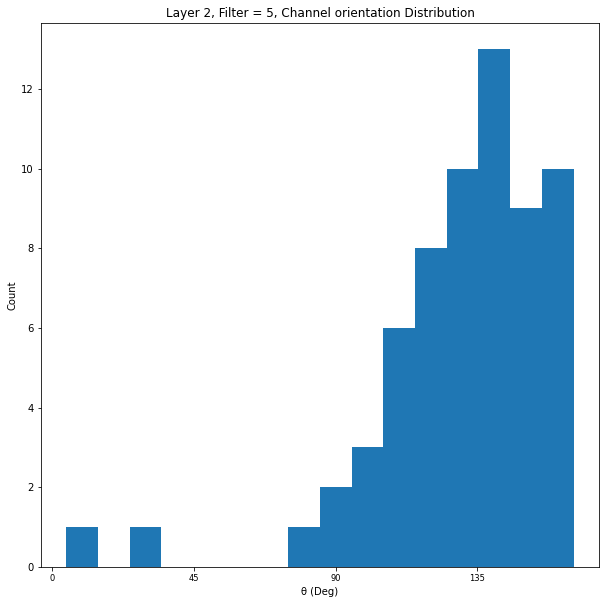

64

In [160]:

LAYER = 2
filters = get_filter(LAYER)

FILTER = [5] #list(range(filters.shape[-1]))
CHANNEL =  list(range(filters.shape[-2]))


thetas = []
anti_mags = []
for i, channel in enumerate(CHANNEL):
    for filter in FILTER:
        
        f = filters[:,:,:, filter]
        f = f[:,:, channel]  
        s, a = getSymAntiSym(f)
        #print("==========(s)
        #print(a)
        #print(getSobelAngle(f)[1, 1])
        sym_mag = np.linalg.norm(s) 
        anti_mag = np.linalg.norm(a) 
        if anti_mag > 0:

            theta = getSobelAngle(f)
            theta = theta[theta.shape[0]//2, theta.shape[1]//2]
            thetas.append(theta)
            anti_mags.append(anti_mag)
plt.hist(thetas, bins=16)
plt.xticks(np.arange(0, 180, step=45), size='small', rotation=0)    
plt.title("Layer {}, Filter = {}, Channel orientation Distribution".format(str(LAYER), FILTER[0]))
plt.xlabel('θ (Deg)')
plt.ylabel('Count')
plt.show()
len(thetas)

In [143]:
n = np.var(thetas)
n

3165.3176

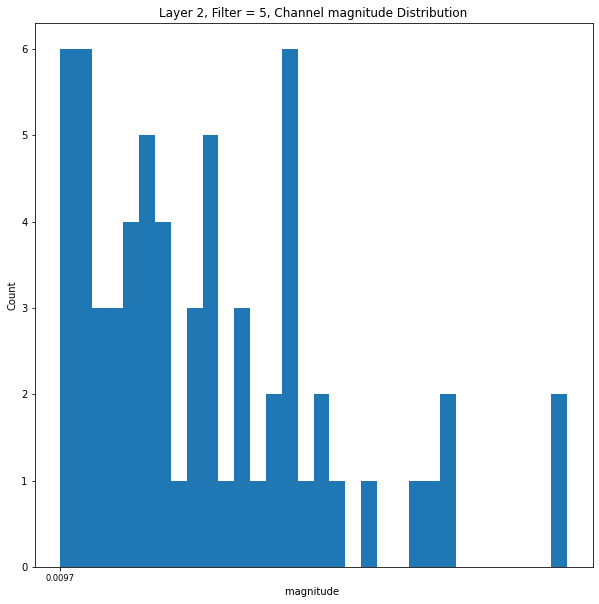

64

In [161]:
plt.hist(anti_mags, bins=32)
plt.xticks(np.arange(np.min(anti_mags), np.max(anti_mags), step=45), size='small', rotation=0)    
plt.title("Layer {}, Filter = {}, Channel magnitude Distribution".format(str(LAYER), FILTER[0]))
plt.xlabel('magnitude ')
plt.ylabel('Count')
plt.show()
len(anti_mags)


In [139]:
np.cov(thetas, anti_mags)

array([[ 2.07484338e+03, -5.56713625e-01],
       [-5.56713625e-01,  2.21414295e-03]])

In [ ]:
#Calculations for circular variance:
#https://www.ebi.ac.uk/thornton-srv/software/PROCHECK/nmr_manual/man_cv.html

In [162]:
t_rad = np.deg2rad(thetas)
n = t_rad.shape
r = np.sqrt(np.sum(np.cos(t_rad))**2 + np.sum(np.sin(t_rad))**2)
1 - r/n

array([0.10151336])

In [163]:
n = np.var(anti_mags)
n

0.005610185

biases shape :  (64,)
filters shape :  (3, 3, 3, 64)
(3, 3)
biases shape :  (64,)
filters shape :  (3, 3, 64, 64)
(3, 3)


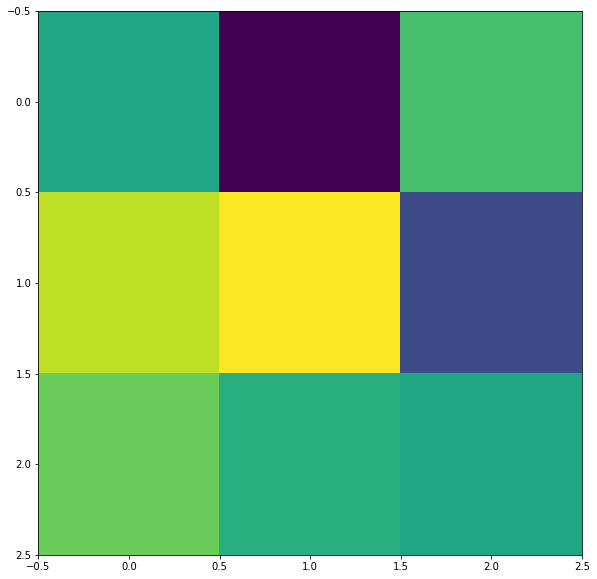

In [113]:
import skimage.measure

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)
LAYER = 1
filters = get_filter(LAYER)

filter = 11
channel =  1
f = filters[:,:,:, filter]
f1 = np.sum(f[:,:, :], axis=-1)
print(f1.shape)


out = f1
for layer in range(2, 3):
    try:
        filters = get_filter(layer)
        f = filters[:,:,:, filter]
        f = np.sum(f[:,:, :], axis=-1)
        out = out* f
        print(out.shape)

    except:
        skimage.measure.block_reduce(out, (2,2), np.max)



plt.imshow(out)


In [149]:
1 - np.exp(-(9.997342e-05**2)/2)

4.9973423177362974e-09

In [150]:
np.sqrt(9.997342e-05)

0.009998670911676211